In [3]:
from bertopic import BERTopic
import pandas as pd
import json
import matplotlib.pyplot as plt

In [15]:
# load data setof all countries, years and sources
data_file = '../data/all_countries_0.0.2.csv'
all_countries_data = pd.read_csv(data_file, dtype={'year': str}, comment='#')
# cast sentence column to string
all_countries_data['sentence'] = all_countries_data['sentence'].astype(str)

In [16]:
# choose a country and year
country = ["hungary"]
year = "2020"
df = pd.DataFrame(all_countries_data)
country_data = df[(df['year'] == year) & (df['country'].isin(country))]
# reset index; needed for proper parsing by BERT
country_data = country_data.reset_index(drop=True)
data_len = len(country_data)

In [17]:
# show length of corpus
print(f"corpus size is {data_len} sentences.")
# show first 10 sentences
print(country_data.iloc[:10]['sentence'])

corpus size is 1142 sentences.
0    The National Assembly elects both the presiden...
1    The president’s duties are mainly ceremonial, ...
2    The president is limited to a maximum of two t...
3    János Áder, a founding member of Fidesz, has b...
4    Orbán has been prime minister since 2010, winn...
5    Voters elect representatives every four years ...
6    The coalition of Fidesz and its junior partner...
7    The far-right Movement for a Better Hungary (J...
8    An election-monitoring mission performed by th...
9    While there was no evidence of electoral fraud...
Name: sentence, dtype: object


In [18]:
# load dictionary of topics
# strcuture [{"name": TOPIC_NAME, "words": NGRAMS_OF_KEYWORDS}, ...]
dict_file = '../data/dict.json'
dictionary = None
with open(dict_file, 'r') as file:
     dictionary = json.load(file)
    
def get_seed_lists(dictionary, ngram_size):
    # create list of topics wit max ngram_size
    seeds = []
    for topic in dictionary:
        seed = [w for w in topic["words"] if len(w.split()) <= ngram_size]
        seeds.append(seed)
    return seeds

In [19]:
seeds = get_seed_lists(dictionary, 1)
print(seeds)

[['accountable', 'legitimacy', 'unconstitutional', 'irregularities', 'ceremonial', 'president', 'impartiality', 'limitations', 'transparent', 'donations', 'lgbt+', 'runoff', 'monarchy', 'autonomy', 'right-wing', 'left-wing', 'transgender', 'women', 'muslim', 'immigrants', 'centrist', 'refugees', 'audits', 'polls', 'clientelism', 'referendum', 'wiretapping', 'surveillance', 'homophobic', 'nationalist', 'sexist', 'lobbying'], ['corruption', 'transparency', 'contracts', 'accountability', 'lobbying', 'protests', 'nepotism', 'bribery', 'fraud', 'patronage', 'monitoring', 'openness', 'improprieties', 'subsidies', 'recommendations', 'amendments', 'embezzlement', 'whistle-blowers', 'e-governance', 'cronyism', 'meritocracy', 'scrutiny', 'rigging', 'antimafia', 'benefits', 'trustees', 'wrongdoing', 'donation', 'loopholes', 'mafia', 'malfeasance', 'mismanagement', 'impunity'], ['constitution', 'inconsistencies', 'detainees', 'lgbt+', 'impartiality', 'independence', 'defendants', 'war', 'insurgenc

In [29]:
# load BERT model paraphrase-MiniLM-L3-v2 (multilingual) or all-MiniLM-L6-v2 (english)
# setting min_topic_size to 7 and n_grams from 1 to 3
# we need to explore these parameters. Other parameters:
# https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html
# guided topic modeling: https://maartengr.github.io/BERTopic/getting_started/guided/guided.html
# seed_topic_list = [["corruption"],
#                   ["elections", "election", "assembly"],
#                  ["freedom", "liberty"]]
seed_topic_list = get_seed_lists(dictionary, 2)
model = BERTopic(seed_topic_list=seed_topic_list, verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 5, n_gram_range=(1, 2))
# model = BERTopic(verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 10, n_gram_range=(1, 3))
# fit model to our data
topics, _ = model.fit_transform(country_data.sentence)

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

2023-05-22 16:26:15,394 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-05-22 16:26:17,335 - BERTopic - Reduced dimensionality
2023-05-22 16:26:17,356 - BERTopic - Clustered reduced embeddings


In [30]:
# generate topic-document probability matrix
topic_distr, _ = model.approximate_distribution(country_data.sentence, min_similarity=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.30it/s]


In [31]:
# get topic information
freq = model.get_topic_info()
# print topic information
print(f"Number of topics: {len(freq)}")
print(freq.head())

Number of topics: 42
   Topic  Count                                   Name
0     -1    285                        -1_the_in_to_of
1      0    106          0_of_hungary_european_council
2      1     90  1_media_media pluralism_the_the media
3      2     78                  2_fidesz_the_party_to
4      3     48       3_corruption_integrity_of_public


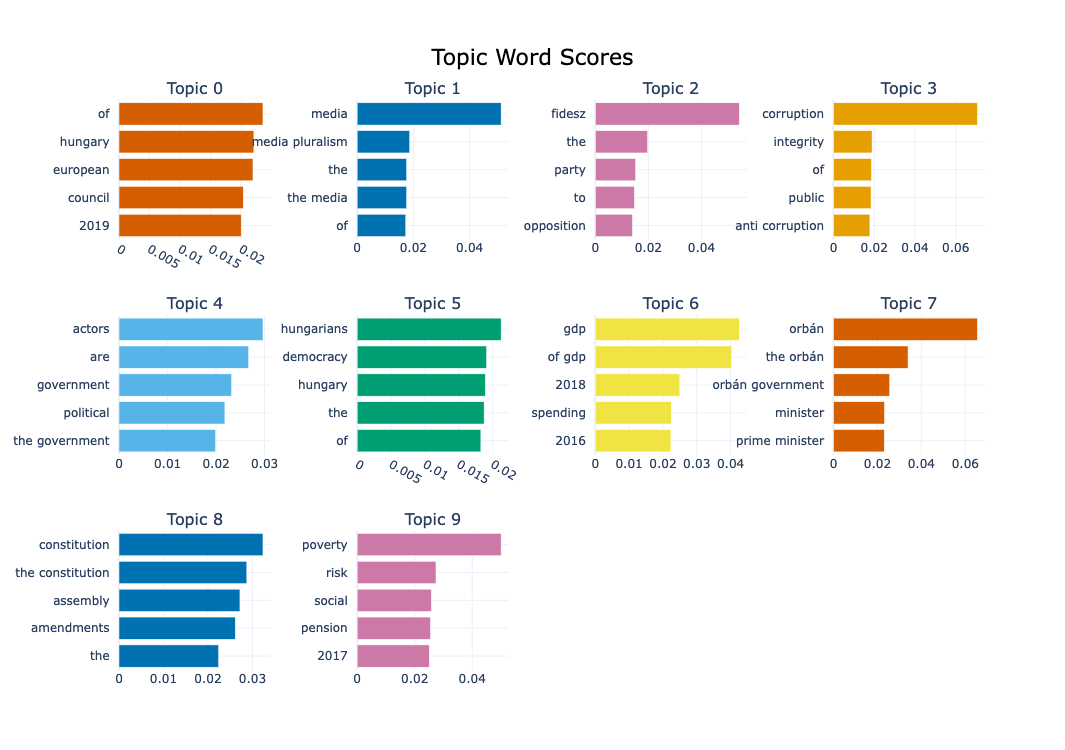

In [32]:
# visualize topic words/n_grams
model.visualize_barchart(top_n_topics=10)

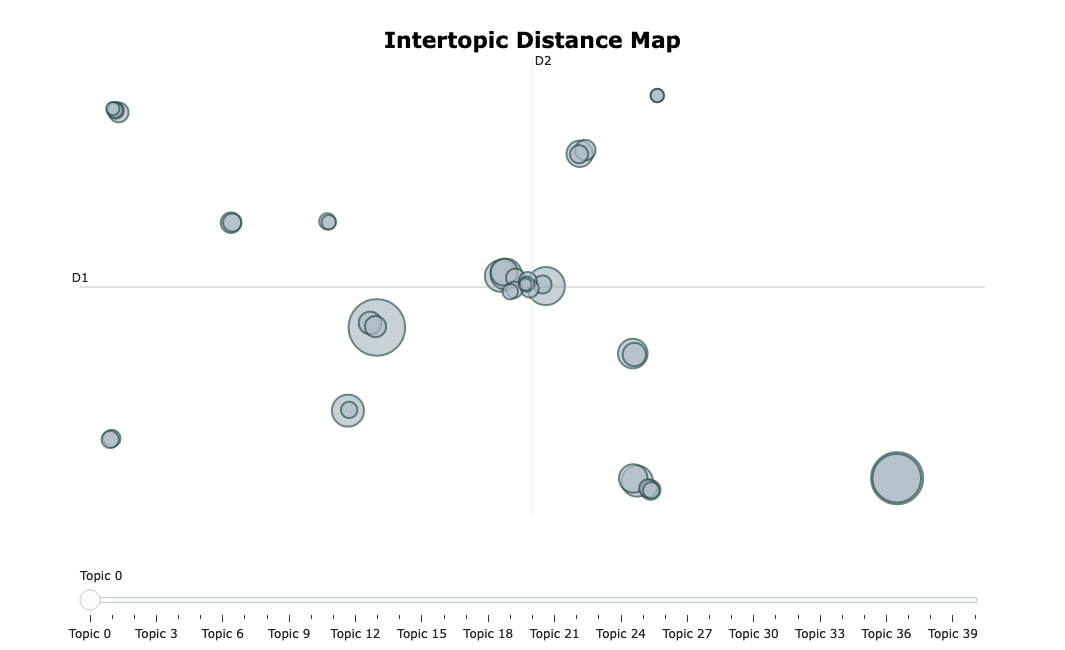

In [33]:
model.visualize_topics()

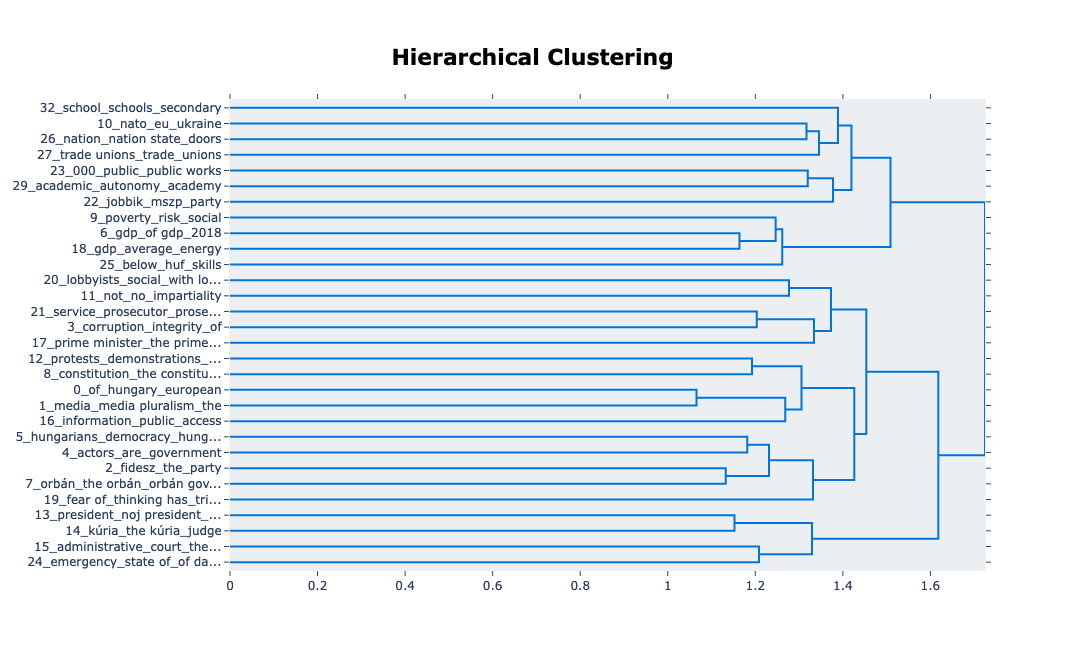

In [34]:
# visualize topic clusters
model.visualize_hierarchy(top_n_topics=30)

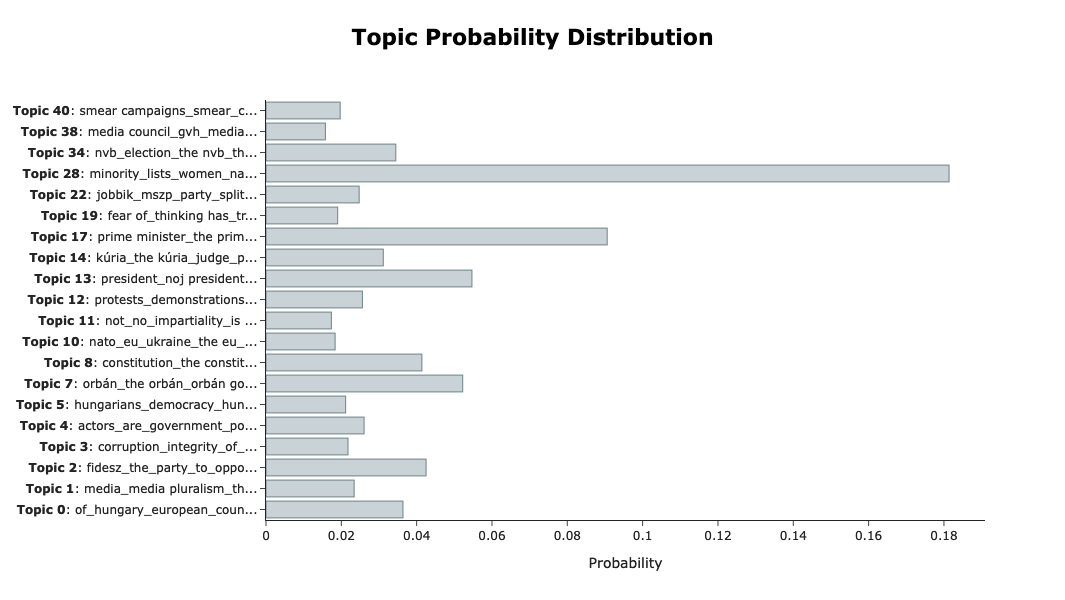

In [35]:
model.visualize_distribution(topic_distr[0])

In [36]:
# search for similar topics
topics = ["freedom", "rule of law", "liberty", "journalism", "pizza"]
for topic in topics:
    similar_topics, similarities = model.find_topics(topic, top_n = 1)
    # most_similar = similar_topics[0]
    print(f"---{topic.upper()}---")
    for most_similar, similarity in zip(similar_topics, similarities):
        print(f"Most Similar Topic Info: {model.get_topic(most_similar)}")
        print(f"Most Similar Topic Number: {most_similar}")
        print(f"Similarity Score: {similarity}")


---FREEDOM---
Most Similar Topic Info: [('constitution', 0.03236346792063721), ('the constitution', 0.02873022910148157), ('assembly', 0.02718323702168838), ('amendments', 0.026139276844335306), ('the', 0.022386873631486334), ('to', 0.022272725957540734), ('religious', 0.019493596961310134), ('law', 0.01862288479814094), ('the government', 0.017399071635316763), ('of assembly', 0.015970884215781238)]
Most Similar Topic Number: 8
Similarity Score: 0.6294060732423827
---RULE OF LAW---
Most Similar Topic Info: [('administrative', 0.05651053546093318), ('court', 0.0523630320619841), ('the constitutional', 0.03524799951177377), ('administrative court', 0.03438770621452832), ('constitutional', 0.03394144419593419), ('constitutional court', 0.02998645525561465), ('omnibus', 0.02579077966089624), ('procedure', 0.024812975600252335), ('court system', 0.023974364673468158), ('the', 0.02277621056420784)]
Most Similar Topic Number: 15
Similarity Score: 0.502847368415493
---LIBERTY---
Most Similar 

In [37]:
# save model
model.save(f"../data/{country[0]}_{year}")

# loading model
# model=BERTopic.load("../data/file")